In [1]:
# 导入需要的python 库
import numpy as np
import pandas as pd
from collections import defaultdict
import math

# Plotting and Utils
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# 分类模型
from sklearn.ensemble import RandomForestClassifier

# 评估
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
# 导入网络访问数据
# 通过分析网络流量来学习正常和异常行为，尝试将神经网络模型应用到入侵检测中，来解决高误报率的问题
# 数据集选择CICIDS2017，这是加拿大网络安全研究所于2017年发布的数据集
# 使用Pandas对CICIDS2017数据集进行数据预处理，清洗数据集并标准化
import datetime

start_time = datetime.datetime.now()
CSV_FILE_PATH = './binary_classification.csv'
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Target
0,80,33643,3,5,26,11601,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,1
1,80,11326939,5,0,30,0,6,6,6.000000,0.000000,...,3970.0,0.0,3970,3970,11300000.0,0.0,11300000,11300000,DDoS,1
2,80,3225962,4,0,24,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,1
3,80,148739,3,5,363,11595,363,0,121.000000,209.578148,...,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk,1
4,80,700948,3,5,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,DDoS,1


In [3]:
#Object类型转换为离散数值（Label列）
df['Label'] = pd.Categorical(df['Label'])
df['Label'] = df['Label'].cat.codes
df.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Target
0,80,33643,3,5,26,11601,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,1,1
1,80,11326939,5,0,30,0,6,6,6.000000,0.000000,...,3970.0,0.0,3970,3970,11300000.0,0.0,11300000,11300000,1,1
2,80,3225962,4,0,24,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,1,1
3,80,148739,3,5,363,11595,363,0,121.000000,209.578148,...,0.0,0.0,0,0,0.0,0.0,0,0,2,1
4,80,700948,3,5,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,1,1


In [4]:
#将int类型转换为float类型
columns_counts = df.shape[1]                                                #获取列数
for i in range(columns_counts):
  if(df.iloc[:,i].dtypes) != 'float64':
    df.iloc[:, i] = df.iloc[:,i].astype(float)
df.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Target
0,80.0,33643.0,3.0,5.0,26.0,11601.0,20.0,0.0,8.666667,10.263203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,80.0,11326939.0,5.0,0.0,30.0,0.0,6.0,6.0,6.000000,0.000000,...,3970.0,0.0,3970.0,3970.0,11300000.0,0.0,11300000.0,11300000.0,1.0,1.0
2,80.0,3225962.0,4.0,0.0,24.0,0.0,6.0,6.0,6.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,80.0,148739.0,3.0,5.0,363.0,11595.0,363.0,0.0,121.000000,209.578148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,80.0,700948.0,3.0,5.0,26.0,11607.0,20.0,0.0,8.666667,10.263203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


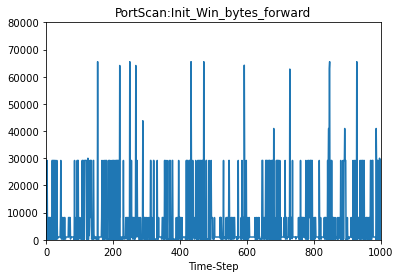

In [5]:
#将特征随时间变化用图像展示出来
ts = df['Init_Win_bytes_forward']
ts.plot(title='PortScan:Init_Win_bytes_forward')
plt.xlabel('Time-Step')
plt.ylim(0,80000)
plt.xlim(0,1000)
plt.show()

In [7]:
#选取11个特征和Label
features_considered = ['Target','Bwd_Packet_Length_Min','Subflow_Fwd_Bytes','Total_Length_of_Fwd_Packets','Fwd_Packet_Length_Mean','Bwd_Packet_Length_Std','Flow_Duration','Flow_IAT_Std','Init_Win_bytes_forward','Bwd_Packets/s',
                 'PSH_Flag_Count','Average_Packet_Size']
feature_last = ['Bwd_Packet_Length_Min','Subflow_Fwd_Bytes','Total_Length_of_Fwd_Packets','Fwd_Packet_Length_Mean','Bwd_Packet_Length_Std','Flow_Duration','Flow_IAT_Std','Init_Win_bytes_forward','Bwd_Packets/s',
                 'PSH_Flag_Count','Average_Packet_Size']
feature = df[features_considered]
print(len(feature))

50960


In [8]:
#将数据集分为训练集、验证集、测试集
train, test = train_test_split(feature,test_size=0.2)

In [9]:
#标准化
def normalize_dataset(dataset, dataset_mean, dataset_std, insert_target):
    dataset = (dataset-dataset_mean)/dataset_std # 归一化公式
    final_dataset = pd.DataFrame(dataset, columns=feature_last)
    final_dataset.insert(0, 'Target', insert_target)
    return final_dataset

In [10]:
train.reset_index(drop=True,inplace=True)                                   #重置索引，很关键！
train_target = train['Target'] # 取出目标
train_other = train[feature_last] 
train_dataset = train_other.values
train_mean = train_dataset.mean(axis=0) # 平均值
train_std = train_dataset.std(axis=0)  # 方差
train = normalize_dataset(train_dataset, train_mean, train_std, train_target)

#对测试集进行标准化时使用训练集的均值和标准差
test.reset_index(drop=True,inplace=True)
test_target = test['Target']
test_other = test[feature_last]
test_dataset = test_other.values
test = normalize_dataset(test_dataset, train_mean, train_std, test_target)


In [11]:
#返回时间窗,根据给定步长对过去的观察进行采样  history_size为过去信息窗口的大小，target_size为模型需要预测的未来时间
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size                                      #如果未指定end_index,则设置最后一个训练点

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])                                      #仅仅预测未来的单个点
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [12]:
past_history = 10000
future_target = 100
STEP = 6


In [13]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)            #dataset[:,1]取最后一列的所有值
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

NameError: name 'dataset' is not defined

In [68]:
# 测试训练集合
from sklearn.metrics import accuracy_score
y_hat = rf.predict(test)
# 进行精确度统计
accuracy = accuracy_score(test_target,  y_hat)
# 输出精确度
print(accuracy)

1.0
